In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
import wta
np.set_printoptions(precision=3, suppress=True)

# time
from time import time

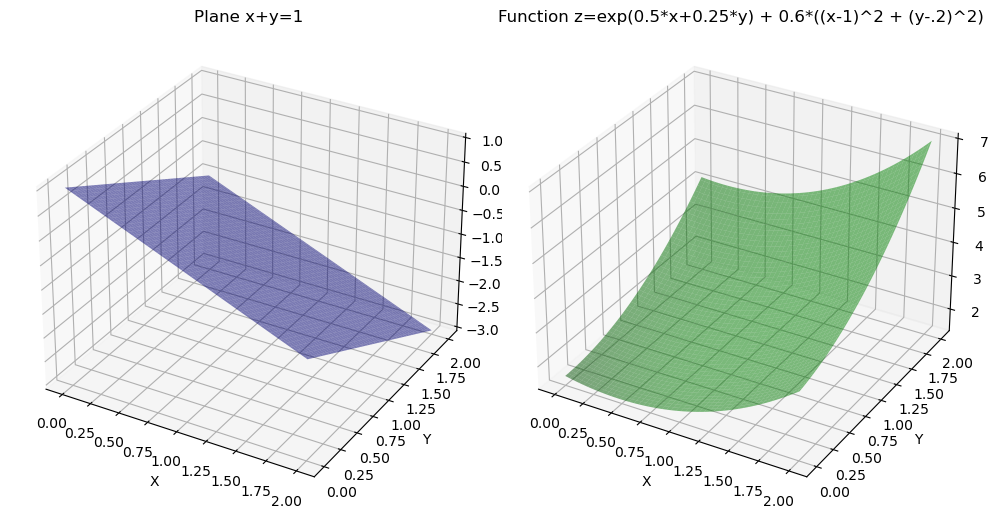

In [1]:
# Visualize prox

# Define the plane equation
def plane(x):
    return 1 - x

# Define the function equation
def func(x, y):
    return np.exp(0.5 * x + 0.25 * y) + 0.6 * ((x - 1) ** 2 + (y - 0.2) ** 2)

# Create a grid of points for the plane
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
plane_y = plane(x)
z = np.linspace(0, 2, 100)

# Create a grid of points for the function
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z_func = func(X, Y)

# Create the 3D plot
fig = plt.figure(figsize=(10, 6))

# Plot the plane
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, color='blue', alpha=0.5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Plane x+y=1')

# Plot the function
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z_func, color='green', alpha=0.5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Function z=exp(0.5*x+0.25*y) + 0.6*((x-1)^2 + (y-.2)^2)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [5]:
# 3x3 problem data

# Define the number of variables
wpns = 3
tgts = 3
m = (tgts, wpns)
V = np.ones(tgts)

# Define the variables
x = cp.Variable(m, boolean=True)

# Define parameters
pk = np.array([[.8, .5, .2], [.5, .8, .1], [.3, .3, .3]])
q = 1 - pk
a = -np.log(q)

y = cp.Parameter(m)
y.value = np.ones(m)/wpns

print(a)

[[1.609 0.693 0.223]
 [0.693 1.609 0.105]
 [0.357 0.357 0.357]]


In [10]:
# WTA full problem
weighted_weapons = cp.multiply(x, np.log(q)) # (n,m)
z = cp.exp(cp.sum(weighted_weapons, axis=1)) # (n,)
cons = [cp.sum(x, axis=0) <= 1, x >= 0]
actual_obj = cp.Minimize(V@z)
actual_prob = cp.Problem(actual_obj, cons)
actual_prob.solve()
print(x.value)
print(z.value)
prox_obj = cp.Minimize(V@z + 0.5*cp.sum_squares(x-y))
prox_prob = cp.Problem(prox_obj, cons)
prox_prob.solve()
print(x.value)
print(z.value)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0.2 0.2 0.7]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0.2 0.2 0.7]


In [52]:
# Change y
y3 = y.value
y3[2,:] = [.8, 1, 10]
print(y3)
max_index = np.argmax(y3, axis=0)
print(max_index)


[[ 0.333  0.333  0.333]
 [ 0.333  0.333  0.333]
 [ 0.8    1.    10.   ]]
[2 2 2]


In [10]:
from collections import deque, defaultdict

def testVal(fullValue, cost, i, j, x):
    if fullValue[j] > cost[j]:
        x[i,j] = 1
        return False
    return True
    
def betterProx(i, q_row, y, Vj, verbose=False):
    pk_i = 1 - q_row
    tgts, wpns = y.shape
    x = np.zeros(y.shape)
    # Put the index of the max value in each column of y into an array of size wpns
    max_index = np.argmax(y, axis=0)
    if verbose:print(max_index)
    # If index i is the max value in column j, set x[i,j] = 1
    # These are weapons favored by the prox matrix y
    remaining = set()
    for j in range(wpns):
        if max_index[j] == i:
            x[i,j] = 1
        else:
            remaining.add(j)
    if verbose:print("remaining",remaining)
    # Look at remaining weapons
    y_sq = np.power(y, 2)
    y_sq_total = np.sum(y_sq, axis=0)
    y_sq_total_i = y_sq_total - y_sq[i,:] + (1-y[i,:])**2
    cost = 0.5*y_sq_total_i
    if verbose:print("cost", cost)
    alt_cost = 0.5*(y_sq_total + [(1-y[max_index[j],j])**2-y_sq[max_index[j],j] for j in range(wpns)])
    if verbose:print("alt_cost", alt_cost)
    cost_diff = cost-alt_cost
    full_val = np.prod(q_row)
    full_val_i = (full_val/q_row)*pk_i
    if verbose:print("full_val", full_val_i)
    remove = set(filter(lambda j: full_val_i[j] > cost_diff[j], remaining))
    remaining = remaining.difference(remove)
    if verbose:print("remove", remove)
    if verbose:print("remaining", remaining)

    # Set x[i,j] = 1 if j in remove
    # These weapons have such a high q value that they are worth the cost even if all weapons are used
    for j in remove:
        x[i,j] = 1

    # We can get the lowest possible base value now with these weapon values set
    if verbose:print(np.power(q_row, x[i,:]))
    base_value = Vj*np.prod(np.power(q_row, x[i,:]))
    if verbose:print(base_value)
   
    base_value_i = base_value*pk_i
    if verbose:print("base_value_i", base_value_i)
    if verbose:print("cost_diff", cost_diff)
    bv = {}
    val = {}
    queue = deque()
    promising = []
    promising_set = set()
    remains = {}
    prohibited = defaultdict(list)

    # Find promising weapons - those with a base value higher than the cost if they are the only one added
    for j in remaining:
        v = base_value*pk_i[j] - cost_diff[j]
        if v > 0:
            bv[j] = base_value*q_row[j]
            val[j] = v
            promising.append((j))
            promising_set.add(j)
        else:
            x[max_index[j],j] = 1
    if verbose:print("promising", promising)
    if verbose:print("vals", val)
    if verbose:print("bv", bv)
    for j in promising:
        remains[j] = promising_set.difference({j})
    queue.extend(promising)
    new_queue = []
    tail = []

    # Dynamic programming to find the best combination of promising weapons
    while queue:
        j = queue.popleft()

        settail = True
        for k in remains[j]:
            if verbose:print("j", j, "k", k)
            
            if type(j) is int:
                jk = {j,k}
            else:
                jk = set(j)
                jk.add(k)
            tjk = tuple(jk)
            if tjk not in bv:
                new_bv = bv[j]*q_row[k]
                v = bv[j]*pk_i[k] - cost_diff[k]
                if v > 0:
                    settail = False
                    if verbose:print("v", v, "val[j]", val[j], "k", k, "j", j, "tjk", tjk)
                    val[tjk] = v + val[j]
                    bv[tjk] = new_bv
                    new_queue.append(tjk)
                else:
                    prohibited[j].append(k)
        if settail:
            tail.append(j)
        for p in new_queue:
            if verbose:print(p)
            r = remaining.difference(p).difference({j for j in prohibited[i] for i in p})
            if r:
                queue.append(p)
                remains[tuple(p)] = r
            else:
                tail.append(p)
        new_queue = []

    # Find p in tail with the highest value
    if verbose:print("tail", tail)
    if verbose:print("val", val)
    if tail:
        p = max(tail, key=lambda x: val[x])
    else:
        p = []
    if verbose:print("p", p)
    # Set x[i,j] = 1 if j in p
    if verbose:print("last remaining", remaining)
    for j in remaining:
        if (type(p) is tuple and j in p) or j == p:
            x[i,j] = 1
        else:
            x[max_index[j],j] = 1

    return x
    


In [9]:
betterProx(0, q[0,:], y3, V[0])

NameError: name 'betterProx' is not defined

In [11]:
# Generate a problem instance with weapons in each category:
# 1. weapon favored by the y matrix (i.e. the max value is in position 0 for this column)
# 2. weapon strongly unfavored by the y matrix (i.e. the max value is in position 1 for this column and the q value is high)
# 3. weapon weakly unfavored by the y matrix (i.e. the max value is in position 1 for this column and the q value is low enough that 
#    the weapon is not strongly unfavored) - this is the promising category. Want multiple weapons in this category to test the
#    dynamic programming solution

# The problem is to find the best combination of weapons to use in each category to minimize the value of the target

wpns = 6
tgts = 3
# Define the y matrix
y = np.zeros((tgts, wpns))
y[0,:] = [0.5, 0.2, 0.3, 0.3, 0.1, 0.6]
y[1,:] = [0.1, 0.2, 0.3, 0.3, 0.6, 0.2]
y[2,:] = [0.2, 0.21, 0.31, 0.31, 0.6, 0.65]

V0 = 6
q0 = np.array([0.8, 0.8, 0.4, 0.45, 0.5, 0.05])

#xx = betterProx(0, q0, y, V0)
#xx

In [19]:
def refProx(q0, y, V0):
    wpns = q0.shape[0]
    tgts = y.shape[0]
    
    x = cp.Variable((tgts, wpns), boolean=True)
    econs = [cp.sum(x, axis=0) == 1]
    z1 = cp.exp(x[0,:]@cp.log(q0))
    obj1 = cp.Minimize(V0*z1 + 0.5*cp.sum_squares(x-y))
    prob1 = cp.Problem(obj1, econs)
    prob1.solve(verbose=True)
    print(obj1.value)
    return x.value

In [4]:
def getProbVal(i, x, q, V):
    z = cp.exp(x[i,:]@cp.log(q))
    obj = cp.Minimize(V*z + 0.5*cp.sum_squares(x-y))
    return obj.value

In [5]:
def singleWTA(q, V, cost_diff, promising, verbose=False):
    '''
    Solve the weapon-target assignment problem for a single target
    Inputs:
    q: (m,) array of survival probabilities
    V: target value (float)
    cost_diff: (m,) array of the difference between the cost of each weapon and the base value
    promising: list of promising weapons
    Outputs:
    p: list of weapons to use
    '''
    m = len(promising)
    small_q = q[promising]
    print("small_q", small_q)
    small_c = cost_diff[promising]
    print("small_c", small_c)
    print("V", V)
    x = cp.Variable(m, boolean=True)
    ww = x@cp.log(small_q)
    obj = cp.Minimize(V*cp.exp(ww) + x@small_c)
    prob = cp.Problem(obj)
    prob.solve()
    if verbose:print("prob status", prob.status)
    if verbose:print("prob value", prob.value)
    if verbose:print("prob x", x.value)
    used = [i for i in range(m) if x.value[i] > 0.5]
    print(used)
    return np.array(promising)[used]



In [6]:
def smallProx(i, q_row, y, Vj, verbose=False):
    pk_i = 1 - q_row
    tgts, wpns = y.shape
    x = np.zeros(y.shape)
    # Put the index of the max value in each column of y into an array of size wpns
    max_index = np.argmax(y, axis=0)
    if verbose:print(max_index)
    # If index i is the max value in column j, set x[i,j] = 1
    # These are weapons favored by the prox matrix y
    remaining = set()
    for j in range(wpns):
        if max_index[j] == i:
            x[i,j] = 1
        else:
            remaining.add(j)
    if verbose:print("remaining",remaining)
    # Look at remaining weapons
    y_sq = np.power(y, 2)
    y_sq_total = np.sum(y_sq, axis=0)
    y_sq_total_i = y_sq_total - y_sq[i,:] + (1-y[i,:])**2
    cost = 0.5*y_sq_total_i
    if verbose:print("cost", cost)
    alt_cost = 0.5*(y_sq_total + [(1-y[max_index[j],j])**2-y_sq[max_index[j],j] for j in range(wpns)])
    if verbose:print("alt_cost", alt_cost)
    cost_diff = cost-alt_cost
    full_val = np.prod(q_row)
    if verbose:print("full_val", full_val)
    full_val_i = (full_val/q_row)*pk_i
    if verbose:print("full_val", full_val_i)
    if verbose:print("cost_diff", cost_diff)
    high_q = set(filter(lambda j: full_val_i[j] > cost_diff[j], remaining))
    remaining = remaining.difference(high_q)
    if verbose:print("high_q", high_q)
    if verbose:print("remaining", remaining)

    # Set x[i,j] = 1 if j in remove
    # These weapons have such a high q value that they are worth the cost even if all weapons are used
    for j in high_q:
        x[i,j] = 1

    # We can get the lowest possible base value now with these weapon values set
    if verbose:print(q_row, i, x[i,:], np.power(q_row, x[i,:]), Vj)
    base_value = Vj*np.prod(np.power(q_row, x[i,:]))
    if verbose:print(base_value)

    # Find promising weapons - those with a base value higher than the cost if they are the only one added
    base_value_i = base_value*pk_i
    if verbose:print("base_value_i", base_value_i)
    bv = {}
    val = {}
    promising = []
    for j in remaining:
        v = base_value*pk_i[j] - cost_diff[j]
        if v > 0:
            bv[tuple([j])] = base_value*q_row[j]
            val[tuple([j])] = v
            promising.append(j)            
        else:
            x[max_index[j],j] = 1
    if verbose:print("promising", promising)
    if verbose:print("vals", val)
    if verbose:print("bv", bv)
    if promising:
        prom_tuples = [tuple([j]) for j in promising]
        #p = dynProgExp(bv, val, q_row, pk_i, cost_diff, max_index, prom_tuples, verbose=verbose)
        p = singleWTA(q_row, base_value, cost_diff, promising, verbose=verbose)
        for j in promising:
            if j in p:
                x[i,j] = 1
            else:
                x[max_index[j],j] = 1
    return x
    


In [12]:
q0

array([0.8 , 0.8 , 0.4 , 0.45, 0.5 , 0.05])

In [13]:
y

array([[0.5 , 0.2 , 0.3 , 0.3 , 0.1 , 0.6 ],
       [0.1 , 0.2 , 0.3 , 0.3 , 0.6 , 0.2 ],
       [0.2 , 0.21, 0.31, 0.31, 0.6 , 0.65]])

In [14]:
refProx(q0, y, 6)

1.7976


array([[ 1.,  0.,  1.,  1., -0.,  1.],
       [ 0.,  0., -0., -0.,  1.,  0.],
       [ 0.,  1.,  0.,  0., -0.,  0.]])

In [15]:
smallProx(0, q0, y, 6, verbose=False)

small_q [0.8  0.4  0.45]
small_c [0.01 0.01 0.01]
V 0.24000000000000005
[1, 2]


array([[1., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [20]:
wpns = 12
q, V, W = wta.generate_random_problem(4, wpns)
W = np.ones(wpns)


In [22]:
y = np.random.rand(4, wpns) #np.ones((4, wpns))/4 #
refProx(q[0,:], y, V[0])

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Feb 05 12:31:13 PM: Your problem has 48 variables, 1 constraints, and 0 parameters.
(CVXPY) Feb 05 12:31:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 05 12:31:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 05 12:31:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 05 12:31:13 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 05 12:31:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

array([[1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.]])

In [23]:
smallProx(0, q[0,:], y, V[0], verbose=False)

small_q [0.1   0.342 0.217 0.174 0.376 0.648]
small_c [0.878 0.086 0.222 0.435 0.037 0.19 ]
V 1.2970032473043844
[1, 4]


array([[1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.]])

In [29]:
# Generate random solution
y = np.random.rand(4, wpns)
# Set the max value in each column to 1, the rest to 0
x = np.zeros(y.shape)
max_index = np.argmax(y, axis=0)
for j in range(wpns):
    x[max_index[j],j] = 1

print(y)
print(x)

# Get the value of the solution
z = fullValue(q, V, x)
print(z)

# Get value 
wta.wta(q, V, W, integer=True)


[[0.605 0.829 0.575 0.628 0.286 0.587 0.75  0.858 0.755 0.698 0.864 0.323]
 [0.671 0.451 0.382 0.411 0.401 0.317 0.622 0.43  0.974 0.678 0.199 0.427]
 [0.343 0.798 0.88  0.904 0.663 0.27  0.252 0.855 0.528 0.802 0.572 0.733]
 [0.519 0.771 0.569 0.466 0.343 0.068 0.378 0.08  0.983 0.182 0.812 0.875]]
[[0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]]
7.721170481234792
optimal


(0.9661200575861864,
 array([[0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.]]))

In [27]:

def get_final_surv_prob(q, x):
    """
    Get the final probability of kill for each target.
    Inputs:
        q: (n,m) array of survival probabilities
        x: (n,m) array of weapon assignments
    """
    return np.prod(np.power(q, x), axis=1)

def fullValue(q, V, x):
    """
    Get the total value of the problem.
    Inputs:
        V: (n,) array of target values
        q: (n,m) array of survival probabilities
        x: (n,m) array of weapon assignments
    """
    return V@get_final_surv_prob(q, x)



In [1]:
from scipy.special import lambertw

In [7]:
def unconstrained_prox(pk, y, v=1, verbose=False):
    m = len(pk)
    x = cp.Variable(m)
    ww = x@cp.log(1-pk)
    obj = cp.Minimize(v*cp.exp(ww) + 0.5*cp.sum_squares(x-y))
    prob = cp.Problem(obj)
    prob.solve()
    if verbose:print("prob status", prob.status)
    if verbose:print("prob value", prob.value)
    if verbose:print("prob x", x.value)



In [19]:
pk = np.array([0.8, 0.2])
y = np.array([0, 1])

t = time()
unconstrained_prox(pk, y, 2, verbose=True)
print(time()-t)

prob status optimal
prob value 0.754191301871464
prob x [0.751 1.104]
0.01957988739013672


In [21]:
def lambertw_prox(pk, y, v=1, verbose=False):
    q = np.log(1-pk)
    b = q@q
    d = q@y
    z = d - lambertw(b*v*np.exp(d))
    lam = np.exp(z)
    x = y - lam*v*q
    return x

In [28]:
t = time()
x = lambertw_prox(pk, y, 2, verbose=True)
print(x.real)
print(time()-t)

[0.751 1.104]
0.015677928924560547


In [24]:
t = [[1,2] for i in range(5)]

In [41]:
def A(x):
    return 2*(x-2)

bz = -4.881
x_bar = 0.209
x = cp.Variable(1)
obj = cp.Minimize(cp.power(x-2,2) + 0.5*cp.power(.75*x-bz-1.25*x_bar,2))
prob = cp.Problem(obj)
prob.solve()
print("We're assuming x:",x.value,"+ A(x):",A(x.value),"= B_i z + (L-I)_i x:",bz+1.25*x_bar -.75*x.value)



We're assuming x: [0.209] + A(x): [-3.582] = B_i z + (L-I)_i x: [-4.776]


In reality, $x_i = J_\frac{A_i}{(1-L_{ii})^2} (\frac{A_i}{1-L_{ii}} (B_iz + \sum_{j=1}^{i-1} L_{ij} x_j))$

So $A_i(x_i) = (1-L_{ii}) (B_i z + \sum_{j=1}^{i-1} L_{ij} x_j) - (1-L_{ii})^2 x_i$

In [42]:
print('A(x):',A(x.value))

lii = .25
oll = .75
print('Bz + sumLijx:',bz+1.25*x_bar)
print('Predicted', oll*(bz+1.25*x_bar) - oll**2*x.value)


A(x): [-3.582]
Bz + sumLijx: -4.61975
Predicted [-3.582]


In [33]:
2*(2.366-2)

0.7320000000000002

In [34]:
2*(2.366-2)/(.75**2)

1.3013333333333337